# Predicting Subscription Status Based on player characteristics

### Data Science 100 Project - Group 10

- Kyle Nguyen (76276393)
- Jiayin Wang (47186200)
- Clianta Anindya (78508892)


## Introduction

### Background Information
In recent years, the gaming industry has increasingly relied on data to better understand player behavior and improve user engagement.
One area of interest is predicting which players are most likely to subscribe to game-related newsletters, as this can inform targeted recruitment strategies, optimize resource allocation, and improve community building around gaming platforms.

Our group is addressing Question 1 from the project brief: _What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?_

To explore this, we focus specifically on whether player age, total hours played and session count can predict whether a player subscribed to the newsletter. The first two variables are available in the **_players.csv_** dataset (**_Age_** and **_played_hours_**, respectively) while the session count variable will be taken from the sum of the number of rows in the **_sessions.csv_** dataset for each hashed email that is unique per player.

Understanding how these player characteristics relate to newsletter subscription behavior could help stakeholders improve how they engage different player types, and may also provide insights into motivations behind long-term or more invested gameplay.

### Questions
- **Broad question**: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?
- **Specific question**: Can **_age_**, **_played_hours_**, and **_session_count_** predict **_subscribe_** in the data set?
### Description of data sets used

This project is based on data collected by a research group at UBC, led by Professor Frank Wood. The group operates a Minecraft research server (_plaicraft.ai_) where they track how users interact within the virtual world.

We will be using the **players.csv** and **sessions.csv** datasets.

The **players.csv** set has 196 rows, each representing one players, uniquely identified by _hashedEmail_.
There are 7 variables in the **players.csv** data set:
* _experience_: character, indicating player's experience level
* _hashedEmail_: character, unique identifier for each player
* _name_: character, player's name
* _gender_: character, player's gender
* _played_hours_: double, total hour the player has played
* _Age_: double, player's age
* _subscribe_: logical, whether the player subscribes the newsletter

The **sessions.csv** set has 1535 rows, each representing one play session.
There are 5 variables in the **session.csv** data set:
* _hashedEmail_: character, unique identifier connecting session to a player
* _start_time_: character, start time in DD/MM/YYYY HH:MM format
* _end_time_: character, end time in DD/MM/YYYY HH:MM format
* _original_start_time_: double, unix timestamp of start time
* _original_end_time_: double, unix timestamp of end time

## Methods and Results

* describe the methods you used to perform your analysis from beginning to end that narrates the analysis code.
* your report should include code which:
  * loads data 
  * wrangles and cleans the data to the format necessary for the planned analysis
  * performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
  * creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
  * performs the data analysis
  * creates a visualization of the analysis 
  * note: all figures should have a figure number and a legend

#### Load libraries

In [1]:
# Run this cell first to load the libraries and set row view limit before continuing
# Suppress package startup messages with suppressMessages() for cleanliness
suppressMessages(library(repr))
suppressMessages(library(tidyverse))
suppressMessages(library(tidymodels))

options(repr.matrix.max.rows = 6)

#### Load data

In [2]:
# Read the csv files to their corresponding dataframe variable
# Suppress read_csv() messages with suppressMessages() for cleanliness
players <- suppressMessages(read_csv("data/players.csv"))
sessions <- suppressMessages(read_csv("data/sessions.csv"))

#### Wrangle and clean the data to the format necessary for the planned analysis

In [3]:
# Group by hashedEmail and summarize the count of rows aggregated per group
sessions_formatted <- group_by(sessions, hashedEmail) |>
    summarize(session_count = n())

# Left join players to sessions_formatted via hashedEmail to retain all the players rows
# Replace all blank session_counts with 0 (all players with blank session_counts have a 0 for played_hours)
# Rename 'Age' to 'age' for lowercase consistency in the variables
# Convert 'subscribe' to a factor via as.factor()
# Filter only the desired exploratory variables and response variable
# Remove rows with a blank age (there are only 2 NAs in the 'age' column)
# Arrange in ascending order for age, then played_hours, then session_count
players_tidy <- left_join(players, sessions_formatted, by = "hashedEmail") |>
    mutate(session_count = replace_na(session_count, 0)) |>
    rename(age = Age) |>
    mutate(subscribe = as.factor(subscribe)) |>
    select(age, played_hours, session_count, subscribe) |>
    filter(!is.na(age)) |>
    arrange(age, played_hours, session_count)

glimpse(players_tidy)

Rows: 194
Columns: 4
$ age           <dbl> 8, 9, 10, 11, 12, 14, 14, 15, 15, 16, 16, 16, 17, 17, 17…
$ played_hours  <dbl> 0.3, 30.3, 3.6, 2.9, 0.5, 0.2, 17.2, 0.1, 0.1, 0.0, 0.1,…
$ session_count <int> 1, 27, 7, 3, 1, 2, 41, 1, 1, 1, 1, 159, 0, 0, 0, 0, 0, 0…
$ subscribe     <fct> TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TR…


#### Perform a summary of the data set

In [4]:
# Perform summary statistics of variables in the tidied dataframe
summary(players_tidy)

# Directly calculate the means of the quantitative explanatory variables
players_means <- players_tidy |> 
    summarize(
        mean_age = mean(age, na.rm = TRUE),
        mean_played_hours = mean(played_hours, na.rm = TRUE),
        mean_session_count = mean(session_count, na.rm = TRUE)
    )

players_means

      age         played_hours     session_count     subscribe  
 Min.   : 8.00   Min.   :  0.000   Min.   :  0.000   FALSE: 52  
 1st Qu.:17.00   1st Qu.:  0.000   1st Qu.:  0.000   TRUE :142  
 Median :19.00   Median :  0.100   Median :  1.000              
 Mean   :20.52   Mean   :  5.905   Mean   :  7.902              
 3rd Qu.:22.00   3rd Qu.:  0.600   3rd Qu.:  1.000              
 Max.   :50.00   Max.   :223.100   Max.   :310.000              

mean_age,mean_played_hours,mean_session_count
<dbl>,<dbl>,<dbl>
20.52062,5.904639,7.902062


#### Create a visualization of the dataset 

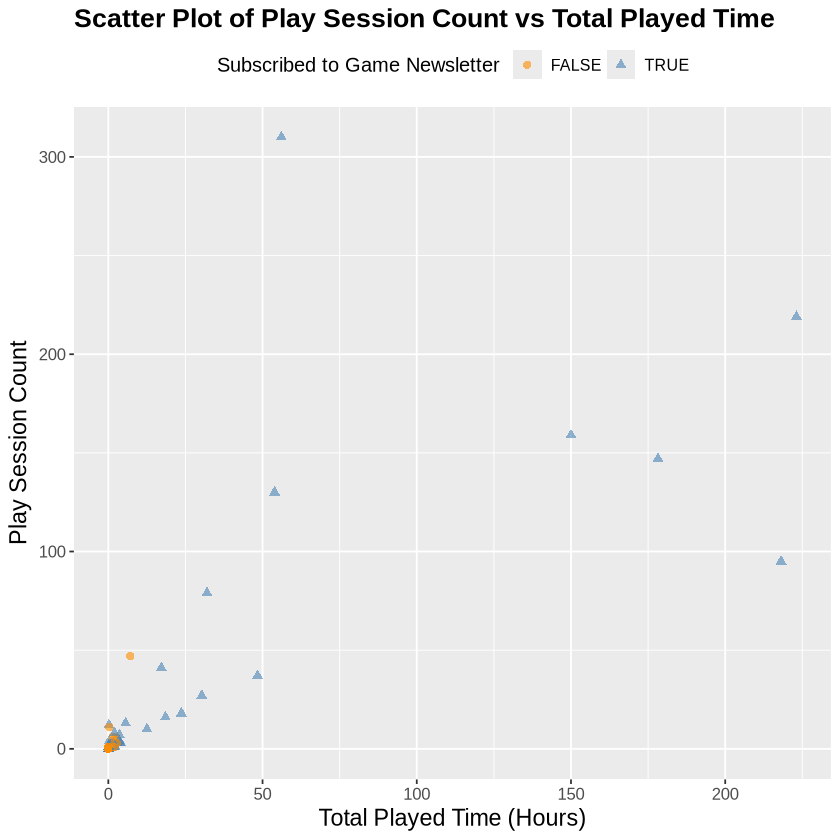

In [5]:
# Scatterplot of Play Session Count vs Total Played Time
ggplot(players_tidy, aes(x = played_hours, y = session_count, color = subscribe, shape = subscribe)) +
    geom_point(alpha = 0.6, size = 2) +
    labs(
        title = "Scatter Plot of Play Session Count vs Total Played Time",
        x = "Total Played Time (Hours)",
        y = "Play Session Count",
        color = "Subscribed to Game Newsletter",
        shape = "Subscribed to Game Newsletter"
    ) +
    scale_color_manual(values = c("darkorange", "steelblue")) +
    theme(
        text = element_text(size = 12),
        legend.position = "top",
        plot.title = element_text(face = "bold", size = 16),
        axis.text = element_text(size = 10),
        axis.title = element_text(size = 14)
    )

In [6]:
# Create the K-NN model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
    set_engine("kknn") |>
    set_mode("classification")

# Create the centering / scaling recipe
recipe <- recipe(subscribe ~ age + played_hours + session_count, data = players_tidy) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_fit <- workflow() |>
  add_recipe(recipe) |>
  add_model(knn_spec) |>
  fit(data = players_tidy)

knn_fit

new_observation <- tibble(age = c(17, 17, 30, 30), played_hours = c(0, 10, 0, 10), session_count = c(0, 3, 0, 3))
prediction <- predict(knn_fit, new_observation)

prediction

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(7,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2268041
Best kernel: rectangular
Best k: 7

.pred_class
<fct>
TRUE
TRUE
FALSE
TRUE


### **Discussions**

* summarize what you found
* discuss whether this is what you expected to find?
* discuss what impact could such findings have?
* discuss what future questions could this lead to?